<a href="https://colab.research.google.com/github/davidsjohnson/evalxai_studies/blob/final-newds/notebooks/blockies_dataselection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms as T

from PIL import Image


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

torch.backends.cudnn.benchmark = True

In [2]:
torch.__version__

'2.5.1+cu124'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Params

In [5]:
# CLASSES = ['Healthy', 'OC Degeneration 2', 'OC Degeneration 1']
CLASSES = ['Healthy', 'OC Degeneration']

modeltype = 'mobilenet'

ds = 'sick_ones_bendbias_v3_2class_normal'
eval_ds = 'sick_ones_bendbias_v3_2class_variation'

random_state = 42
save_dataset = False

In [6]:
gdrive = Path('/content/drive/MyDrive/')
notebook_folder = 'two4two_dataselection_pytorch'

notebook_path = gdrive / notebook_folder
os.makedirs(notebook_path, exist_ok=True)
os.chdir(notebook_path)

# Setup and Load Datasets

In [7]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = Path(cache_dir) / file_name

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      file_path = Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)
    elif not extract and archive_folder is not None:
       file_path = Path(cache_dir) / archive_folder
       print(f"File already extracted to: {file_path}")

    return Path(file_path)

def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)

  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

# data selection processing
def check_range(df, column, range):
    return (abs(df[column]) > range[0]) & (abs(df[column]) < range[1])

In [8]:
# download data direcly from sciebo
# (or setup own data location if prefered)
data_dir = download_file(url="https://osf.io/download/kexzt/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5",
                         file_name="blockies_datasets.tar.gz",
                         cache_dir='/content/data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='blockies_datasets')
data_dir

100%|██████████| 1.00G/1.00G [01:28<00:00, 12.2MB/s]


File downloaded to: /content/data/blockies_datasets.tar.gz
File extracted to: /content/data


PosixPath('/content/data/blockies_datasets')

In [9]:
ds_dir = data_dir / ds
eval_ds_dir = data_dir / eval_ds
ds_dir, eval_ds_dir

(PosixPath('/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_normal'),
 PosixPath('/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_variation'))

In [10]:
# load datasets and dataloaders for pytorch processing
# load datasets and dataloaders for Training and Evaluation
# mean = [0.8075, 0.7839, 0.8011]
# std = [0.1063, 0.1113, 0.1025]

# 2 class dataset
mean = [0.8068, 0.7830, 0.8005]
std = [0.1093, 0.1136, 0.1029]


transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')
eval_df = load_dataframe(eval_ds_dir, 'test')
eval_hard_df = load_dataframe(eval_ds_dir, 'test')

print(len(train_df), len(val_df), len(test_df), len(eval_df), len(eval_hard_df))

test_df['sphere_diff'] = np.abs(test_df['spherical'] - test_df['ill_spherical'])
eval_df['sphere_diff'] = np.abs(eval_df['spherical'] - eval_df['ill_spherical'])
eval_hard_df['sphere_diff'] = np.abs(eval_hard_df['spherical'] - eval_hard_df['ill_spherical'])

train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False,
                              num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                             num_workers=6, pin_memory=True)

eval_dataset = ImageDataset(eval_df,  eval_ds_dir / 'test', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False,
                             num_workers=6, pin_memory=True)

40000 1000 3000 3000 3000


In [11]:
abs(eval_df[['obj_rotation_roll', 'obj_rotation_pitch']]).describe()

obj_rotation_roll  obj_rotation_pitch
count        3000.000000         3000.000000
mean            0.515382            0.516314
std             0.300949            0.301045
min             0.000178            0.001081
25%             0.257045            0.260166
50%             0.511162            0.507514
75%             0.768926            0.769287
max             1.047006            1.046644

In [12]:
# remove some samples from same domain to make task  bit more difficult
roll_range = (.0, .35)
pitch_range = (.0, .35)
roll_remove = check_range(eval_hard_df, 'obj_rotation_roll', roll_range)
pitch_remove = check_range(eval_hard_df, 'obj_rotation_pitch', pitch_range)

eval_hard_df = eval_hard_df.drop(eval_hard_df[roll_remove | pitch_remove].index)
print(len(eval_df), len(eval_hard_df))

eval_hard_dataset = ImageDataset(eval_hard_df,  eval_ds_dir / 'test', transform=transform)
eval_hard_dataloader = DataLoader(eval_hard_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

3000 1306


In [13]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [14]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    preds = []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy, np.array(preds)


In [15]:
checkpoint_path = download_file(url='https://osf.io/download/5crqh/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5',
                                file_name='best_model.pth',
                                cache_dir='/content/model/mobilenetv2_checkpoint', # change this if not using Colab
                                extract=False,
                                force_download=True)

100%|██████████| 8.73M/8.73M [00:02<00:00, 3.15MB/s]

File downloaded to: /content/model/mobilenetv2_checkpoint/best_model.pth


In [16]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Evaluate Model on All Datasets

In [17]:
# load best model and evaluate
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path)
model.to(device);

<ipython-input-13-8ca1eb820737>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint from: /content/model/mobilenetv2_checkpoint/best_model.pth


In [18]:
# train set
loss, acc, preds = evaluate_model(model, train_dataloader, criterion, device)
preds = np.array(preds)
train_df['pred'] = preds

train_corr_pred = train_df['pred'] == train_df['ill'].astype(int)
print(f'Acc: {train_corr_pred.astype(int).mean():.4f}')

Evaluation Loss: 0.0913, Evaluation Accuracy: 0.9682
Acc: 0.9682


In [19]:
# train set
loss, acc, preds = evaluate_model(model, val_dataloader, criterion, device)
preds = np.array(preds)
val_df['pred'] = preds

val_corr_pred = val_df['pred'] == val_df['ill'].astype(int)
print(f'Acc: {val_corr_pred.astype(int).mean():.4f}')

Evaluation Loss: 0.2097, Evaluation Accuracy: 0.9130
Acc: 0.9130


In [20]:
# test set
loss, acc, preds = evaluate_model(model, test_dataloader, criterion, device)
preds = np.array(preds)
test_df['pred'] = preds

test_corr_pred = test_df['pred'] == test_df['ill'].astype(int)
print(f'Acc: {test_corr_pred.astype(int).mean():.4f}')

Evaluation Loss: 0.2286, Evaluation Accuracy: 0.9043
Acc: 0.9043


In [21]:
# eval dataset (with domain shift)
loss, acc, preds = evaluate_model(model, eval_dataloader, criterion, device)
preds = np.array(preds)
eval_df['pred'] = preds

eval_corr_pred = eval_df['pred'] == eval_df['ill'].astype(int)
print(f'Acc: {eval_corr_pred.astype(int).mean():.4f}')

Evaluation Loss: 0.9192, Evaluation Accuracy: 0.6937
Acc: 0.6937


In [22]:
# eval dataset (with domain shift)
loss, acc, preds = evaluate_model(model, eval_hard_dataloader, criterion, device)
preds = np.array(preds)
eval_hard_df['pred'] = preds

eval_hard_corr_pred = eval_hard_df['pred'] == eval_hard_df['ill'].astype(int)
print(f'Acc: {eval_hard_corr_pred.astype(int).mean():.4f}')

Evaluation Loss: 1.2982, Evaluation Accuracy: 0.5995
Acc: 0.5995


# Data Selection

Review data distributions of all datasets and then select images for XAI and Tutorial datasets

## Data Distributions

view of distribitions for various traits of Blockies.

- `spherical`, `ill_spherical`, and `sphere_dff` all represent the bone shape for the main and secondary bones
- `spherical` values above 1 represent a bone mutation
- `bending` represents the amount of bend in the blockies spines
- `arm_position` represents the amount the arms of the blockies are extened or pulled back, affecting whether or not the head peaks out from between the legs
- `obj_rotation_<X>` represents the `pitch`, `yaw`, or `roll` of the bodies (depending on the value of X)


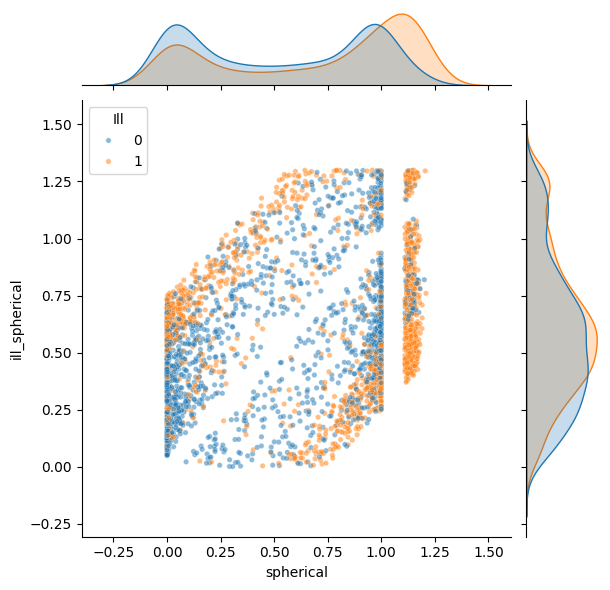

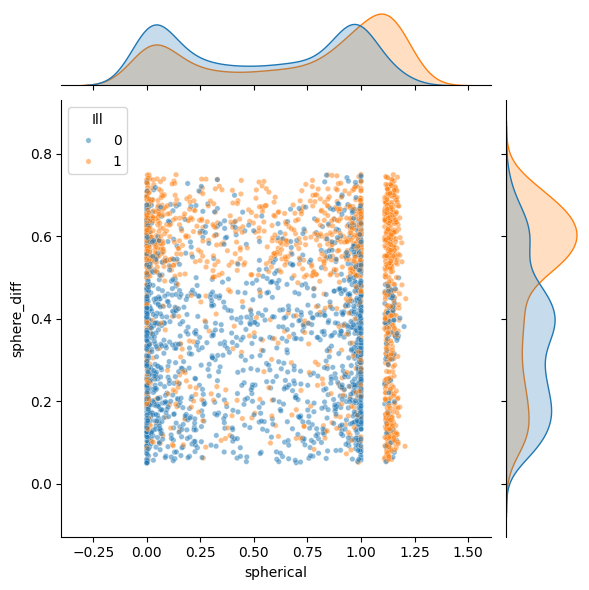

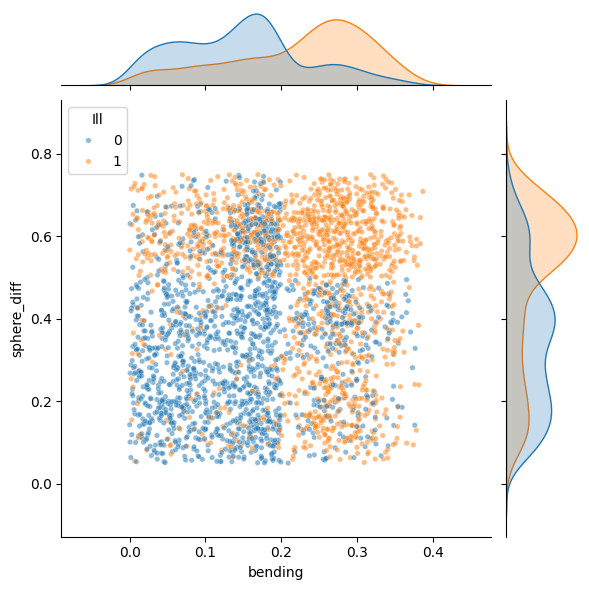

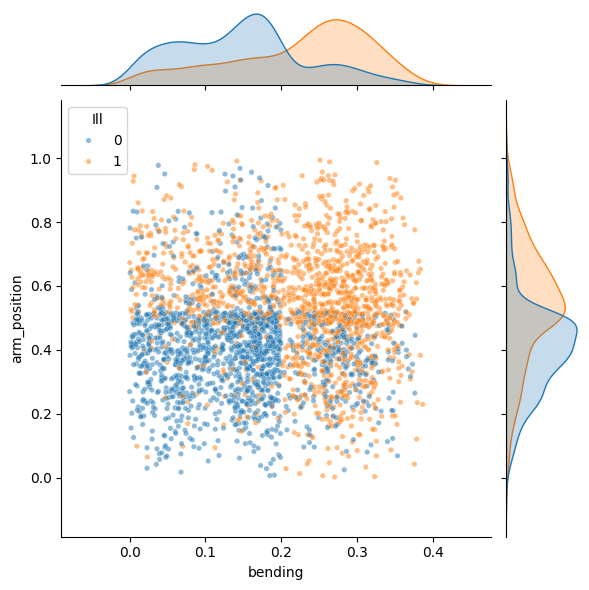

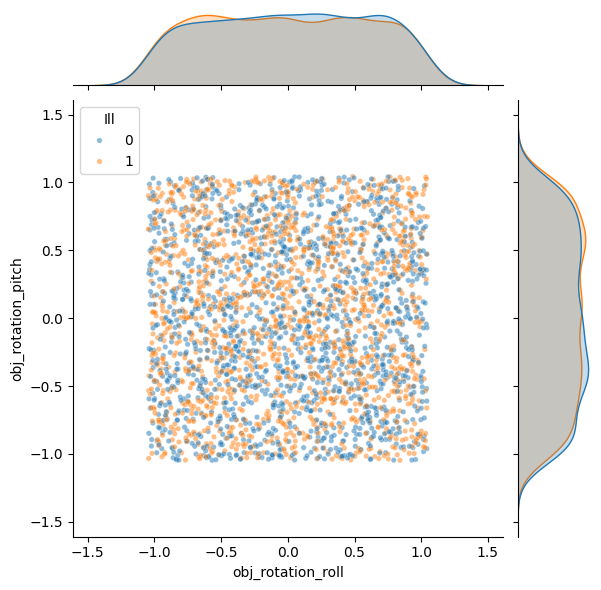

In [23]:
g = sns.jointplot(data=eval_df, x='spherical', y='ill_spherical', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
# g.ax_joint.scatter(eval_df[~eval_corr_pred]['spherical'], eval_df[~eval_corr_pred]['ill_spherical'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)


g = sns.jointplot(data=eval_df, x='spherical', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
# g.ax_joint.scatter(eval_df[~eval_corr_pred]['spherical'], eval_df[~eval_corr_pred]['sphere_diff'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='bending', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
# g.ax_joint.scatter(eval_df[~eval_corr_pred]['bending'], eval_df[~eval_corr_pred]['sphere_diff'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='bending', y='arm_position', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
# g.ax_joint.scatter(eval_df[~eval_corr_pred]['bending'], eval_df[~eval_corr_pred]['arm_position'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='obj_rotation_roll', y='obj_rotation_pitch', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
# g.ax_joint.scatter(eval_df[~eval_corr_pred]['obj_rotation_roll'], eval_df[~eval_corr_pred]['obj_rotation_pitch'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

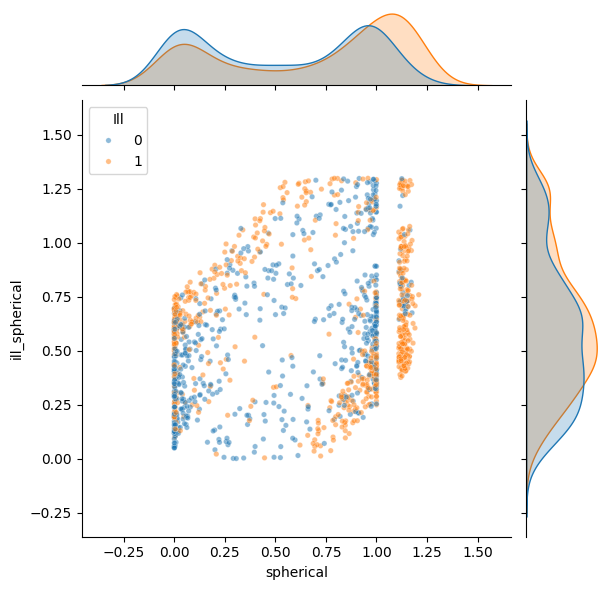

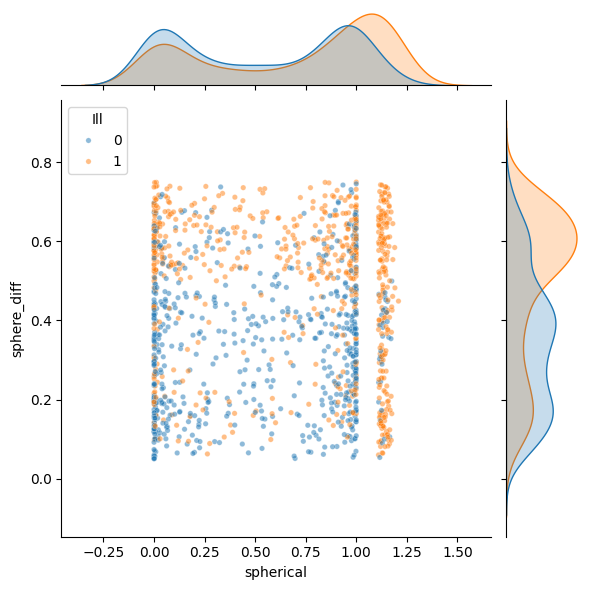

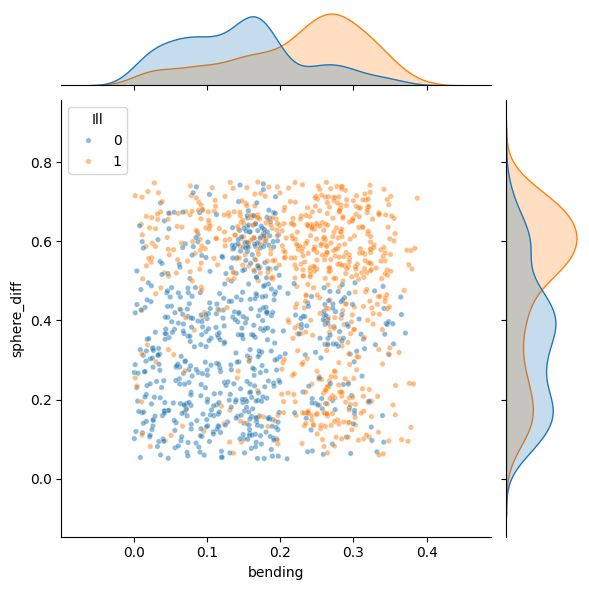

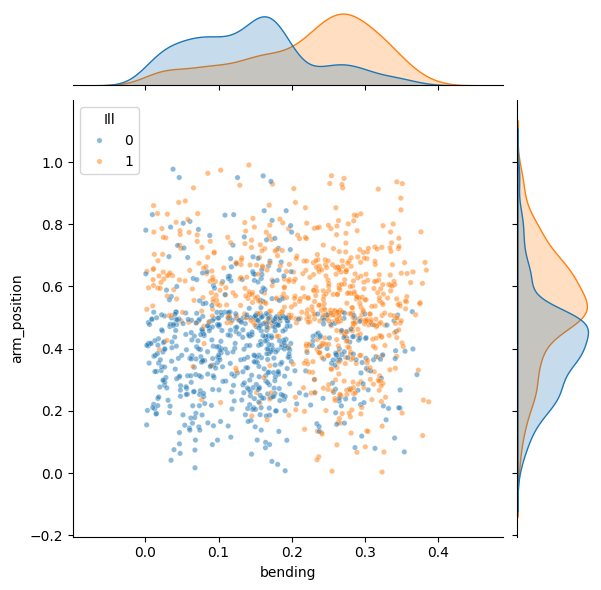

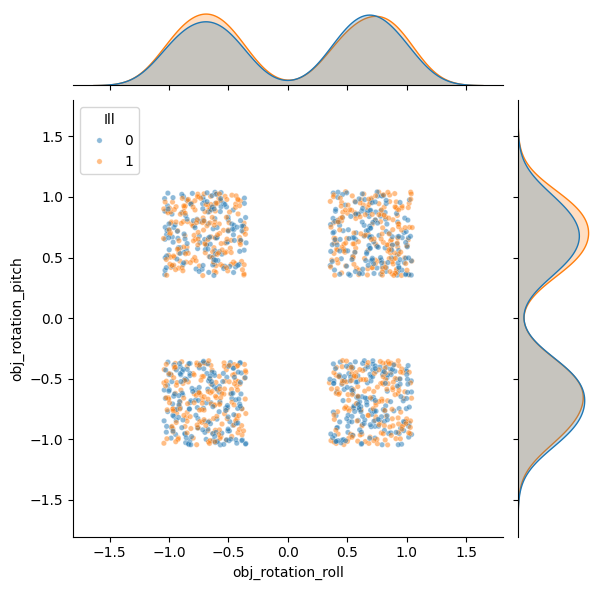

In [24]:
g = sns.jointplot(data=eval_hard_df, x='spherical', y='ill_spherical', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
# g.ax_joint.scatter(eval_hard_df[~eval_hard_corr_pred]['spherical'], eval_hard_df[~eval_hard_corr_pred]['ill_spherical'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)


g = sns.jointplot(data=eval_hard_df, x='spherical', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
# g.ax_joint.scatter(eval_hard_df[~eval_hard_corr_pred]['spherical'], eval_hard_df[~eval_hard_corr_pred]['sphere_diff'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_hard_df, x='bending', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
# g.ax_joint.scatter(eval_hard_df[~eval_hard_corr_pred]['bending'], eval_hard_df[~eval_hard_corr_pred]['sphere_diff'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_hard_df, x='bending', y='arm_position', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
# g.ax_joint.scatter(eval_hard_df[~eval_hard_corr_pred]['bending'], eval_hard_df[~eval_hard_corr_pred]['arm_position'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)


g = sns.jointplot(data=eval_hard_df, x='obj_rotation_roll', y='obj_rotation_pitch', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
# g.ax_joint.scatter(eval_hard_df[~eval_hard_corr_pred]['obj_rotation_roll'], eval_hard_df[~eval_hard_corr_pred]['obj_rotation_pitch'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

## Generate Explanation Dataset

- 28 - Correct predictions
- 12 - Incorrect predictions

represents accuracy of model (around $70\%$)


In [25]:
def display_images(df, n_rows, n_cols, img_dir, title, random_state=0):
  """ Function to display images in a grid randomly selected from a dataframe of images.

  Args:
    df (pd.DataFrame): dataframe of images
    n_rows (int): number of rows in the grid
    n_cols (int): number of columns in the grid
    title (str): title of the plot
    random_state (int): random state for reproducibility
  """

  if n_rows == 0 and n_cols == 0:
    print(f'Not data to display for Figure - {title}')
    return

  if n_rows * n_cols < len(df):
    df = df.sample(n_rows * n_cols, random_state=random_state)

  figsize = (n_cols * 2, n_rows*2.5)
  print(figsize)

  test_images = np.array([Image.open(p).convert('RGB') for p in img_dir / df['filename']]) * 1. / 255
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  axes = np.array(axes)
  for i, (ax, idx) in enumerate(zip(axes.flat, df.index)):
    ax.imshow(test_images[i])
    ax.set_title(f'True={df.loc[idx]["ill"]} - Pred={df.loc[idx]["pred"]}')
    ax.axis('off')

  fig.suptitle(title)
  fig.tight_layout()

In [26]:
# for 2 class problem
# correct
samples_corr = eval_hard_df[eval_hard_corr_pred].groupby(['ill']).sample(14, random_state=random_state)

# incorrect 4 from each class, 2 per predict
samples_inc = eval_hard_df[~eval_hard_corr_pred].groupby(['ill', 'pred']).sample(6, random_state=random_state)

xai_df = pd.concat([samples_corr, samples_inc])
xai_corr = xai_df['ill'].astype(int) == xai_df['pred']
print(f'Acc: {xai_corr.astype(int).mean():.4f}')
xai_df.describe()

Acc: 0.7000


spherical  ill_spherical   num_diff    bending  obj_rotation_roll  \
count  40.000000      40.000000  40.000000  40.000000          40.000000   
mean    0.589736       0.592757   2.125000   0.177178          -0.004417   
std     0.432787       0.292846   0.790569   0.105748           0.713716   
min     0.000377       0.021687   1.000000   0.011305          -1.009053   
25%     0.184718       0.347847   1.750000   0.073787          -0.660898   
50%     0.716196       0.624025   2.000000   0.171717           0.003213   
75%     0.991140       0.802942   3.000000   0.276886           0.686336   
max     1.145970       1.191044   3.000000   0.354080           0.984545   

       obj_rotation_pitch  obj_rotation_yaw  position_x  position_y  \
count           40.000000         40.000000   40.000000   40.000000   
mean             0.047375         -1.328892   -0.406486   -0.375999   
std              0.719339          0.983635    0.248637    0.223354   
min             -1.006324         -3.137685   -0.741958   -0.777833   
25%             -0.614397         -2.272300   -0.615494   -0.557421   
50%              0.069786         -0.999127   -0.390889   -0.388147   
75%              0.722799         -0.463378   -0.180734   -0.152017   
max              0.945636         -0.074309   -0.005405   -0.031096   

       arm_position  obj_color   bg_color  original_id  sphere_diff      pred  
count     40.000000  40.000000  40.000000          0.0    40.000000  40.00000  
mean       0.469654   0.539482   0.475353          NaN     0.407030   0.50000  
std        0.223464   0.273748   0.247076          NaN     0.183975   0.50637  
min        0.081796   0.021128   0.057987          NaN     0.059788   0.00000  
25%        0.246052   0.316542   0.277540          NaN     0.292172   0.00000  
50%        0.492204   0.522210   0.522245          NaN     0.420639   0.50000  
75%        0.667548   0.767683   0.638492          NaN     0.536627   1.00000  
max        0.860225   0.998135   0.907645          NaN     0.696770   1.00000

### View XAI dataset distribution

correct samples in black, incorrect samples in red

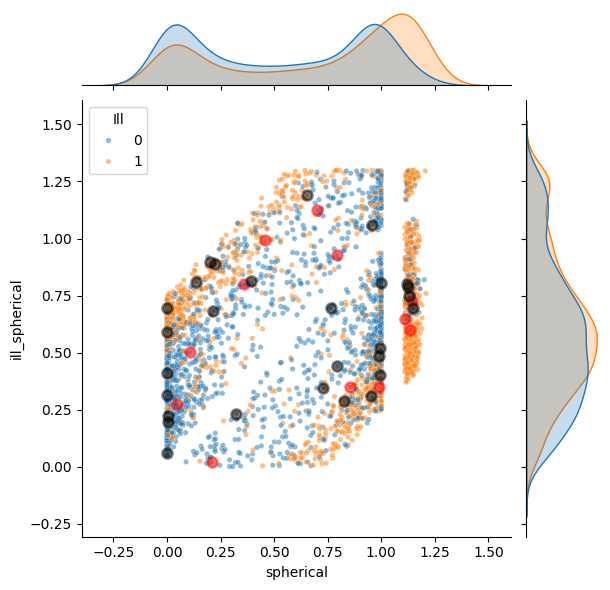

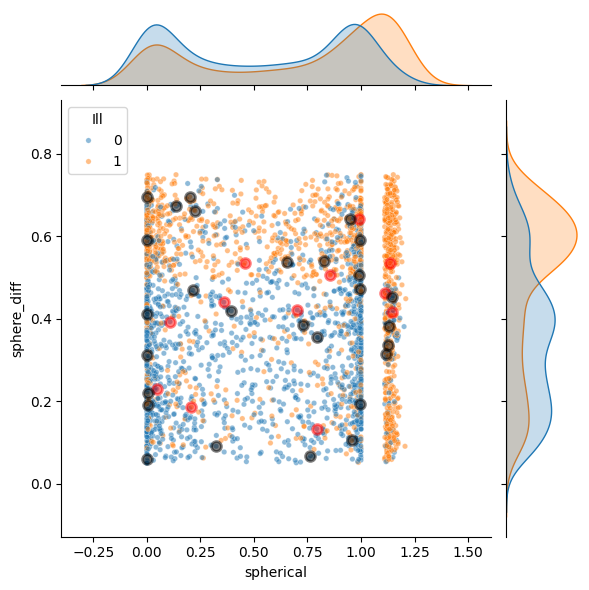

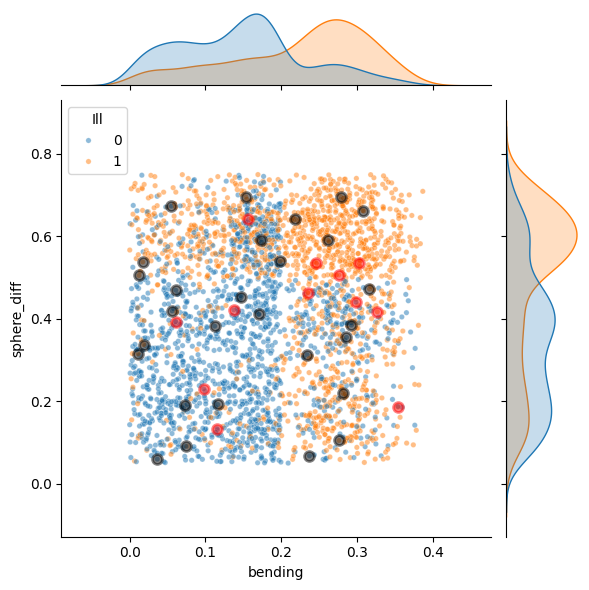

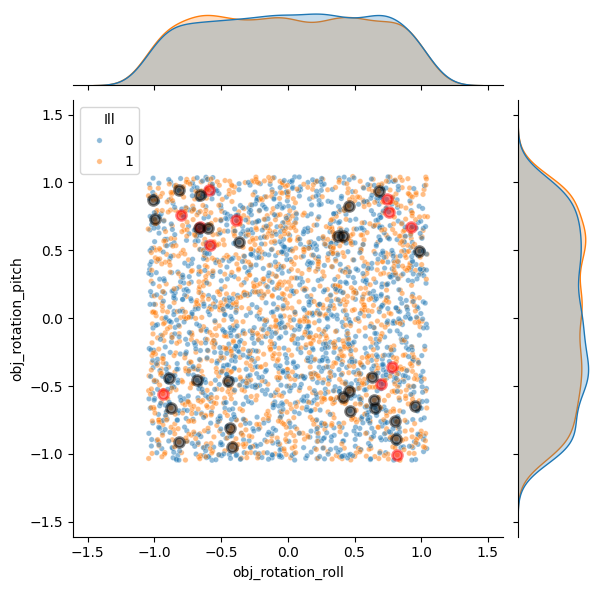

In [27]:
g = sns.jointplot(data=eval_df, x='spherical', y='ill_spherical', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(xai_df[~xai_corr]['spherical'], xai_df[~xai_corr]['ill_spherical'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(xai_df[xai_corr]['spherical'], xai_df[xai_corr]['ill_spherical'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)


g = sns.jointplot(data=eval_df, x='spherical', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(xai_df[~xai_corr]['spherical'], xai_df[~xai_corr]['sphere_diff'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(xai_df[xai_corr]['spherical'], xai_df[xai_corr]['sphere_diff'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='bending', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(xai_df[~xai_corr]['bending'], xai_df[~xai_corr]['sphere_diff'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(xai_df[xai_corr]['bending'], xai_df[xai_corr]['sphere_diff'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='obj_rotation_roll', y='obj_rotation_pitch', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(xai_df[~xai_corr]['obj_rotation_roll'], xai_df[~xai_corr]['obj_rotation_pitch'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(xai_df[xai_corr]['obj_rotation_roll'], xai_df[xai_corr]['obj_rotation_pitch'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

### View Selected Dataset

(6, 22.5)


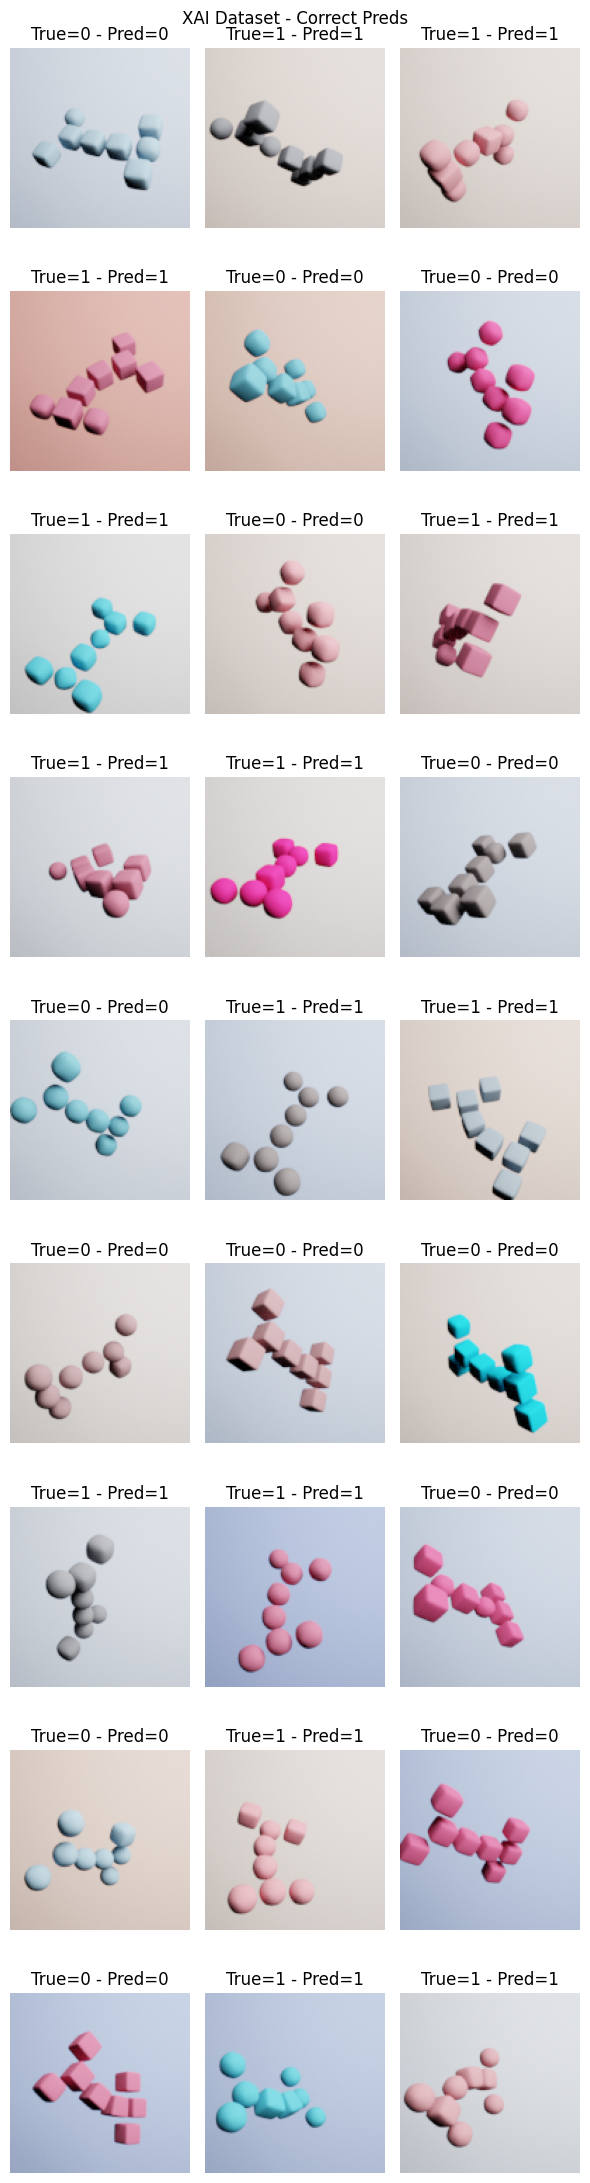

In [28]:
display_images(xai_df[xai_corr], 9, 3, eval_ds_dir / 'test', f'XAI Dataset - Correct Preds', random_state=0)

(6, 10.0)


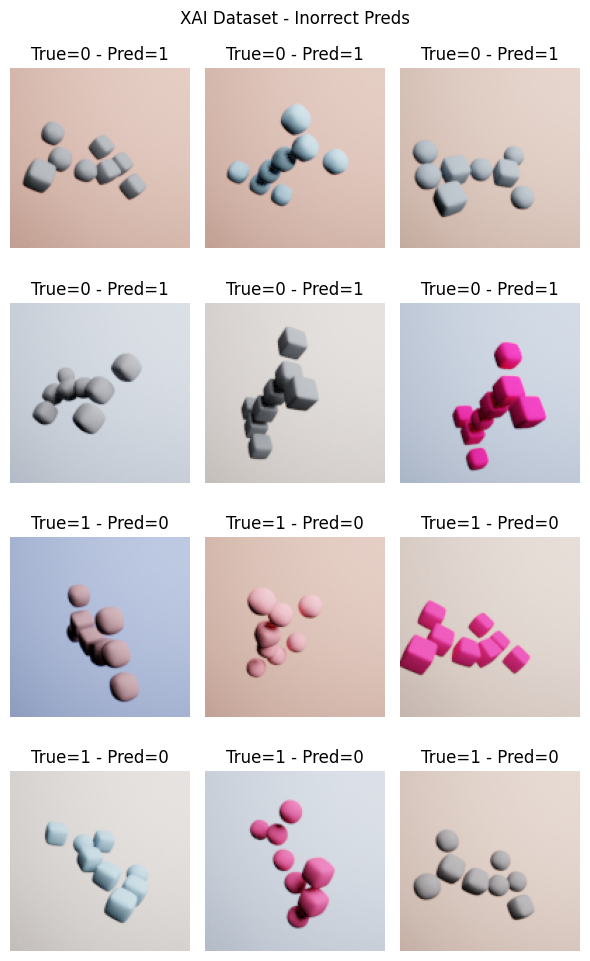

In [29]:
display_images(xai_df[~xai_corr], 4, 3, eval_ds_dir / 'test', f'XAI Dataset - Inorrect Preds', random_state=0)

### Save Inputs

In [30]:
from skimage.transform import resize
import datetime

In [31]:
def show_blocky(image, id, pred=None):

  figsize = [5, 5]
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

  #plot the input image
  ax.imshow(image)
  ax.axis('off')

In [32]:
output = gdrive / 'hcxai' / 'blockies' / 'oc_degeneration_v3_2class'

In [33]:
if save_dataset:
  xai_images = [Image.open(p) for p in eval_ds_dir / 'test' / xai_df['filename']]

  today = datetime.datetime.today()
  date_str = today.strftime('%Y-%m-%d')

  o = output / 'highvar_input' / 'pytorch_model' / date_str / f'xai_samples'
  os.makedirs(o, exist_ok=True)
  print(f'saving to {o}')

  for i, ((idx, row), image) in enumerate(zip(xai_df.iterrows(), xai_images)):
    image.save(o / f'{row["id"]}_true={row["ill"]}_pred={row["pred"]}_input.png')

  # save dataframe
  xai_df.to_csv(o / 'xai_samples_df.csv')

## Generate Tutorial Dataset

Generate seperate sample of data to use in the tutorial

In [34]:
# 15 easy examples for tutorial (80 % accuracy)

rot_max = 0.50
roll_limited = check_range(test_df, 'obj_rotation_roll', (0, rot_max))
pitch_limited = check_range(test_df, 'obj_rotation_pitch', (0, rot_max))

# correct
train_samples_corr = test_df[test_corr_pred].groupby(['ill']).sample(7, random_state=random_state)

# incorrect 4 from each class, 2 per predict
tutor_samples_inc = test_df[~test_corr_pred].groupby(['ill']).sample(3, random_state=random_state)

print(len(train_samples_corr), len(tutor_samples_inc))

tutor_df = pd.concat([train_samples_corr, tutor_samples_inc])
tutor_corr = tutor_df['ill'].astype(int) == tutor_df['pred']
print(f'Acc: {tutor_corr.astype(int).mean():.4f}')

14 6
Acc: 0.7000


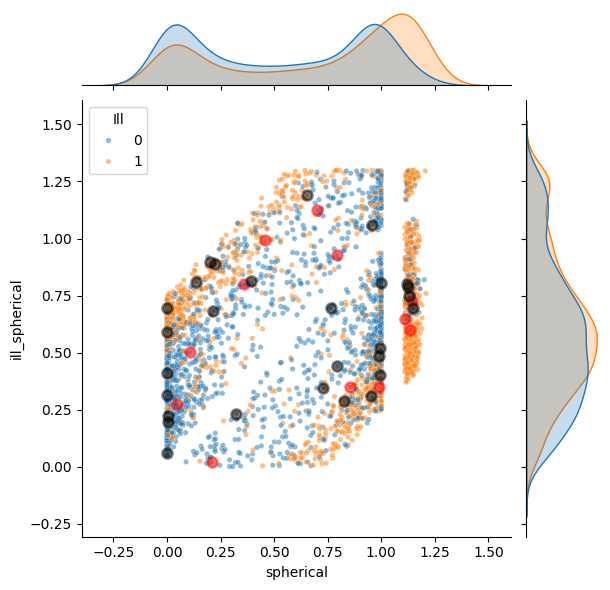

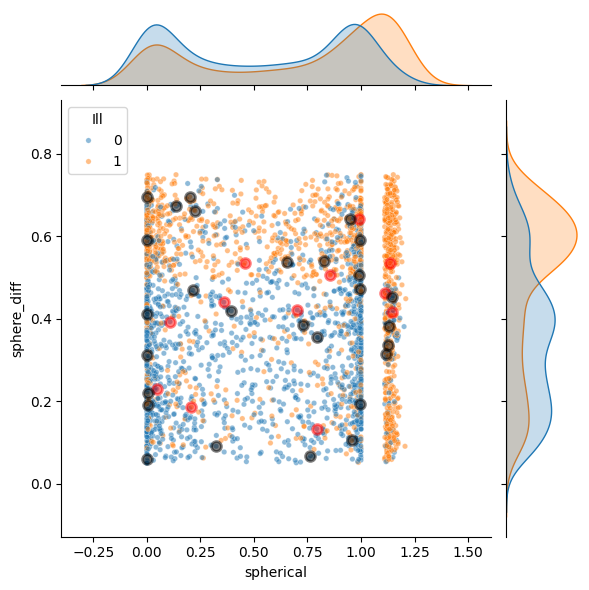

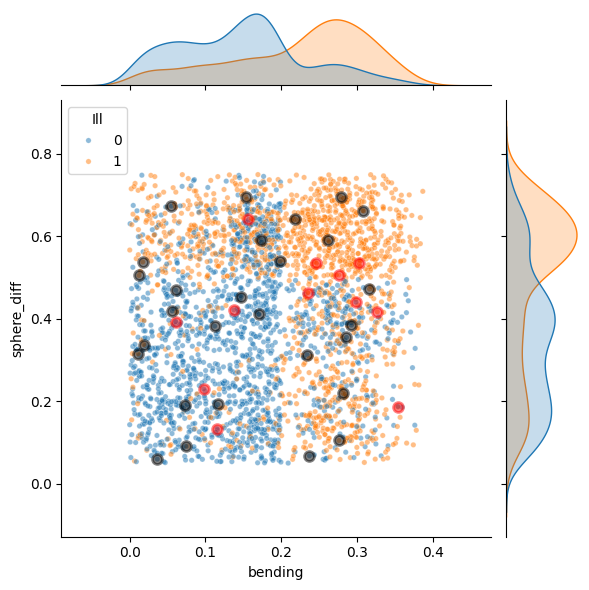

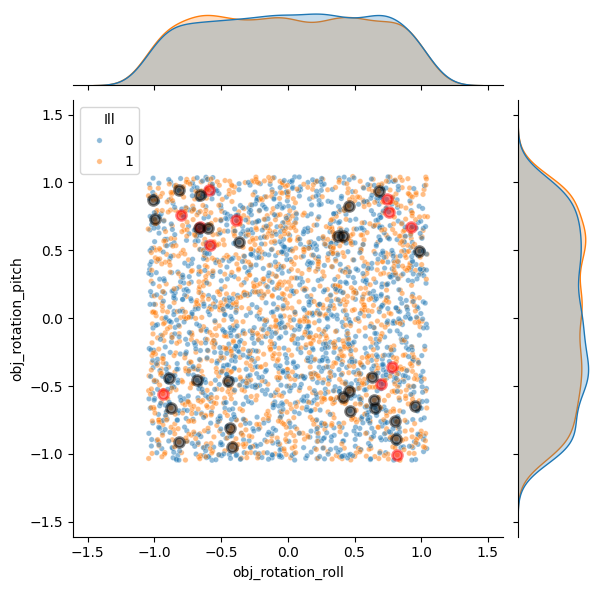

In [35]:
g = sns.jointplot(data=eval_df, x='spherical', y='ill_spherical', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(xai_df[~xai_corr]['spherical'], xai_df[~xai_corr]['ill_spherical'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(xai_df[xai_corr]['spherical'], xai_df[xai_corr]['ill_spherical'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)


g = sns.jointplot(data=eval_df, x='spherical', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(xai_df[~xai_corr]['spherical'], xai_df[~xai_corr]['sphere_diff'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(xai_df[xai_corr]['spherical'], xai_df[xai_corr]['sphere_diff'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='bending', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(xai_df[~xai_corr]['bending'], xai_df[~xai_corr]['sphere_diff'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(xai_df[xai_corr]['bending'], xai_df[xai_corr]['sphere_diff'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=eval_df, x='obj_rotation_roll', y='obj_rotation_pitch', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(xai_df[~xai_corr]['obj_rotation_roll'], xai_df[~xai_corr]['obj_rotation_pitch'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(xai_df[xai_corr]['obj_rotation_roll'], xai_df[xai_corr]['obj_rotation_pitch'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

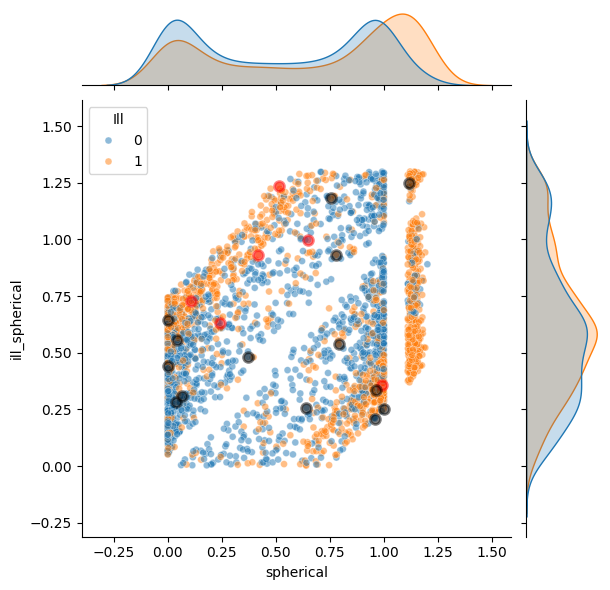

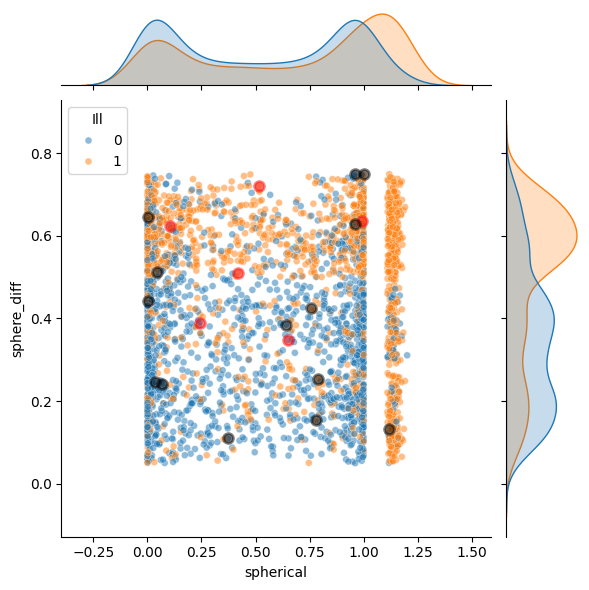

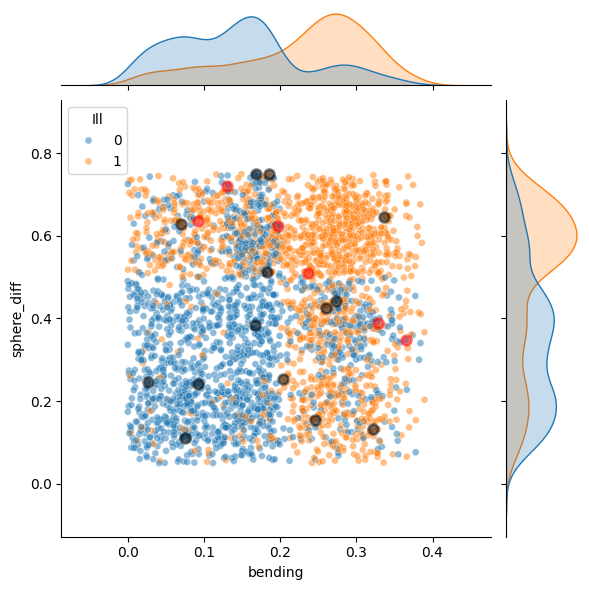

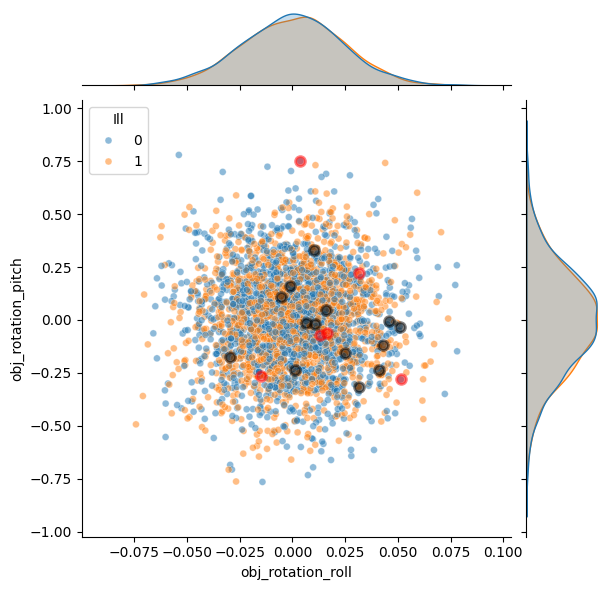

In [36]:
g = sns.jointplot(data=test_df, x='spherical', y='ill_spherical', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(tutor_df[~tutor_corr]['spherical'], tutor_df[~tutor_corr]['ill_spherical'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(tutor_df[tutor_corr]['spherical'], tutor_df[tutor_corr]['ill_spherical'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=test_df, x='spherical', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(tutor_df[~tutor_corr]['spherical'], tutor_df[~tutor_corr]['sphere_diff'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(tutor_df[tutor_corr]['spherical'], tutor_df[tutor_corr]['sphere_diff'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

g = sns.jointplot(data=test_df, x='bending', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(tutor_df[~tutor_corr]['bending'], tutor_df[~tutor_corr]['sphere_diff'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(tutor_df[tutor_corr]['bending'], tutor_df[tutor_corr]['sphere_diff'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)


g = sns.jointplot(data=test_df, x='obj_rotation_roll', y='obj_rotation_pitch', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g.ax_joint.scatter(tutor_df[~tutor_corr]['obj_rotation_roll'], tutor_df[~tutor_corr]['obj_rotation_pitch'], color='red', alpha=0.49, s=50, zorder=1, linewidth=2)
g.ax_joint.scatter(tutor_df[tutor_corr]['obj_rotation_roll'], tutor_df[tutor_corr]['obj_rotation_pitch'], color='black', alpha=0.49, s=50, zorder=1, linewidth=2)

(8, 12.5)


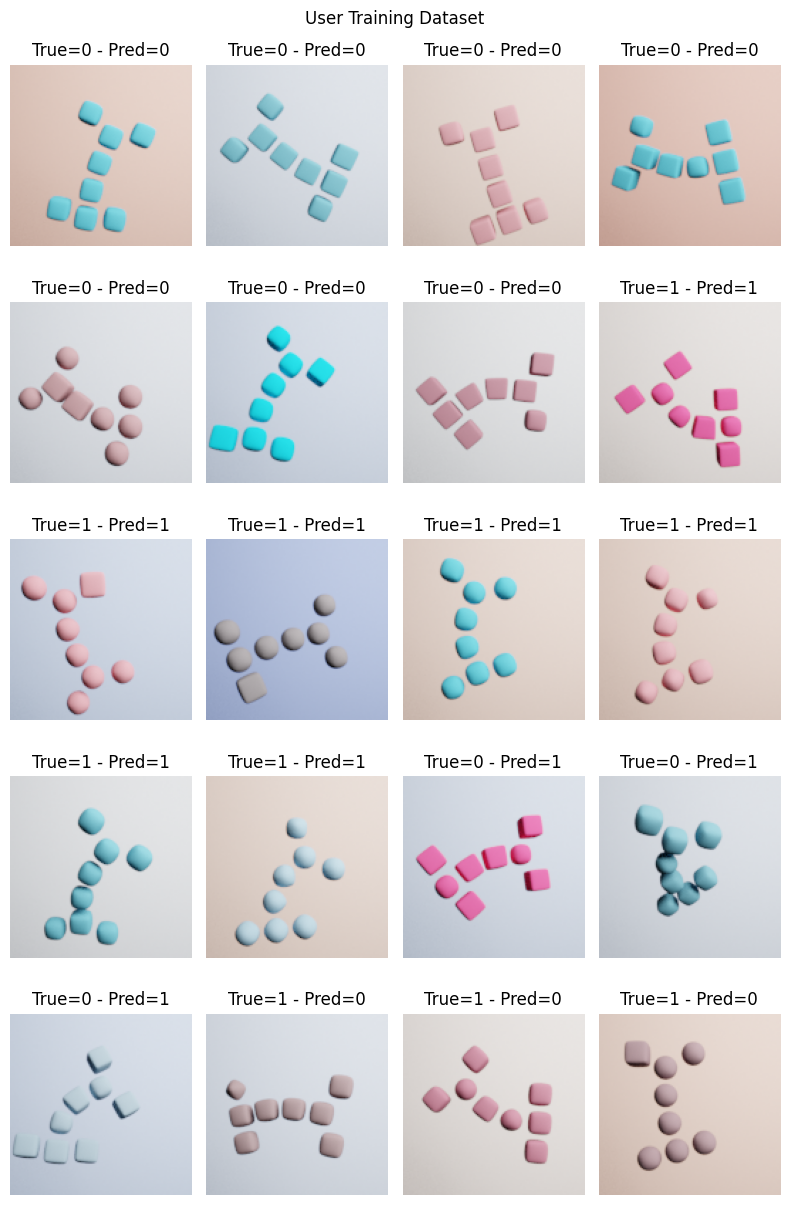

In [37]:
display_images(tutor_df, 5, 4, ds_dir / 'test', 'User Training Dataset')

In [38]:
if save_dataset:

  tutor_images = [Image.open(p) for p in ds_dir / 'test' / tutor_df['filename']]

  today = datetime.datetime.today()
  date_str = today.strftime('%Y-%m-%d')

  o = output / 'highvar_input' / 'pytorch_model' / date_str / f'tutorial_samples' / 'xai_samples'
  os.makedirs(o, exist_ok=True)
  print(f'saving to {o}')

  for i, ((idx, row), image) in enumerate(zip(tutor_df.iterrows(), tutor_images)):
    image.save(o / f'{row["id"]}_true={row["ill"]}_pred={row["pred"]}_input.png')
    show_blocky(image, row["id"], None)
    plt.savefig(o / f'{row["id"]}_true={row["ill"]}_pred={row["pred"]}_input.png')

  tutor_df.to_csv(o / 'training_samples_df.csv')